## 1. Preparing the dataset


<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest (from datacamp project). We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1.

In [46]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv(r'C:\Users\Utilisateur\Downloads\Classify Song Genres from Audio Data\datasets\fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json(r'C:\Users\Utilisateur\Downloads\Classify Song Genres from Audio Data\datasets\echonest-metrics.json',precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(left=echonest_metrics, right=tracks[['track_id', 'genre_top']], on='track_id')

# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


## 2. Normalizing the feature data & PCA
<p>We will use <strong>principal component analysis (PCA)</strong> in order to reduce the dimensionality of our data before implementing our classification algorithms. </p>


[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]
8


Text(0.5, 0, 'Principal Component #')

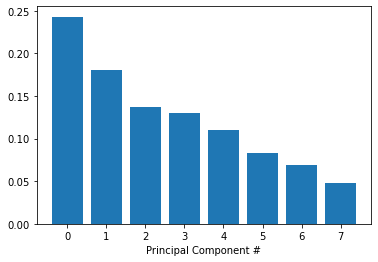

In [47]:
# Define our features 
features = echo_tracks.drop(['genre_top','track_id'],axis=1)

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

print(pca.explained_variance_ratio_)
print(pca.n_components_)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

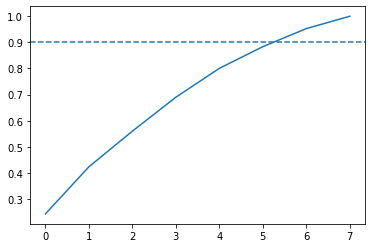

In [48]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(pca.n_components_), cum_exp_variance)
ax.axhline(y=0.90, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)


## 3. Train different classifiers to infer genre
<p>Now we can use the lower dimensional PCA projection of the data to classify songs into genres. To do that, we first need to split our dataset into 'train' and 'test' subsets, where the 'train' subset will be used to train our model while the 'test' dataset allows for model performance validation.</p>

In [49]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear"),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

# iterate over classifiers and compute classification report

for name, clf in zip(names, classifiers):
        clf.fit(train_features, train_labels)
        score = clf.score(test_features,test_labels)
        class_rep = classification_report(test_labels, clf.predict(test_features))
        print(name," \n",class_rep)
    




Nearest Neighbors  
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.68      0.73       235
        Rock       0.92      0.96      0.94       966

    accuracy                           0.90      1201
   macro avg       0.86      0.82      0.84      1201
weighted avg       0.90      0.90      0.90      1201

Linear SVM  
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.52      0.63       235
        Rock       0.89      0.97      0.93       966

    accuracy                           0.88      1201
   macro avg       0.84      0.74      0.78      1201
weighted avg       0.87      0.88      0.87      1201

RBF SVM  
               precision    recall  f1-score   support

     Hip-Hop       0.86      0.41      0.55       235
        Rock       0.87      0.98      0.92       966

    accuracy                           0.87      1201
   macro avg       0.86      0.70      0.74      1201
weighted avg       0.87     

## 4. Balancing the data for greater performance
<p>Looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.</p>
<p>To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in <em>sample size</em> of our data points when weighting our classes here, and not relative importance of each class. </p>

In [50]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks["genre_top"] == "Hip-Hop"]
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)


#Reruns
for name, clf in zip(names, classifiers):
        clf.fit(train_features, train_labels)
        score = clf.score(test_features,test_labels)
        class_rep = classification_report(test_labels, clf.predict(test_features))
        print(name," \n",class_rep)


Nearest Neighbors  
               precision    recall  f1-score   support

     Hip-Hop       0.87      0.83      0.85       230
        Rock       0.83      0.88      0.85       225

    accuracy                           0.85       455
   macro avg       0.85      0.85      0.85       455
weighted avg       0.85      0.85      0.85       455

Linear SVM  
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.79      0.82       230
        Rock       0.80      0.85      0.82       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

RBF SVM  
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.83      0.83       230
        Rock       0.82      0.84      0.83       225

    accuracy                           0.83       455
   macro avg       0.83      0.83      0.83       455
weighted avg       0.83     

In [52]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)


# Train our models using KFold cv
# Print the mean of each array of scores

for name, clf in zip(names, classifiers):
        my_cv_score = cross_val_score(clf, pca_projection, labels, cv=kf)
        print(name,": ", np.mean(my_cv_score))

Nearest Neighbors :  0.8131868131868132
Linear SVM :  0.778021978021978
RBF SVM :  0.7697802197802197
Gaussian Process :  0.8252747252747252
Decision Tree :  0.743956043956044
Random Forest :  0.8203296703296703
Neural Net :  0.8142857142857143
AdaBoost :  0.7873626373626375
Naive Bayes :  0.7978021978021979
QDA :  0.8104395604395604
